# Cleaning: BJH051


This script cleans the data both by abnormal trials and by noisy channels and epileptic activity. 


### Prep

In [1]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
#import mat73
import re
#from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
#from tabulate import tabulate
import IPython
import seaborn as sns

In [2]:
#matplotlib qt5

In [3]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [5]:
## Prep paths ##

subject = 'BJH051'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [6]:
## Load Data ##

raw_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

Opening raw data file /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_raw_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_raw_ieeg-1.fif...
    Range : 2086000 ... 3179999 =   1043.000 ...  1589.999 secs
Ready.


In [7]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.filter(l_freq=1, h_freq=150) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Reading 0 ... 3179999  =      0.000 ...  1589.999 secs...


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   13.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   11.9s


In [8]:
## Load/Save Filtered Data ##

# save #
filtered_notch_data.save(f"{raw_data_dir}/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# load #
# filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/{subject}_notched_filtered_ieeg.fif")
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Writing /home/brooke/pacman/raw_data/BJH051/BJH051_notched_filtered_ieeg.fif
Closing /home/brooke/pacman/raw_data/BJH051/BJH051_notched_filtered_ieeg.fif
Writing /home/brooke/pacman/raw_data/BJH051/BJH051_notched_filtered_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH051/BJH051_notched_filtered_ieeg-1.fif
[done]
480 events found on stim channel STI
Event IDs: [0 1]


In [9]:
filtered_notch_data.info['ch_names']
print(raw_fif.info['ch_names'])


['AL1 ', 'AL2 ', 'AL3 ', 'AL4', 'REF1', 'REF2', 'AL5', 'AL6', 'AL7', 'AL8', 'AL9', 'AL10', 'AL11', 'AL12', 'BL1', 'BL2', 'BL3', 'BL4', 'BL5', 'BL6', 'BL7', 'BL8', 'BL9', 'BL10', 'BL11', 'BL12', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7', 'CL8', 'CL9', 'CL10', 'CL11', 'CL12', 'DL1', 'DL2', 'DL3', 'DL4', 'DL5', 'DL6', 'DL7', 'DL8', 'DL9', 'DL10', 'DL11', 'DL12', 'EL1', 'EL2', 'EL3', 'EL4', 'EL5', 'EL6', 'EL7', 'EL8', 'FL1', 'FL2', 'FL3', 'FL4', 'FL5', 'FL6', 'FL7', 'FL8', 'FL9', 'FL10', 'FL11', 'FL12', 'GL1', 'GL2', 'GL3', 'GL4', 'GL5', 'GL6', 'GL7', 'GL8', 'GL9', 'GL10', 'GL11', 'GL12', 'HL1', 'HL2', 'HL3', 'HL4', 'HL5', 'HL6', 'HL7', 'HL8', 'HL9', 'HL10', 'IL1', 'IL2', 'IL3', 'IL4', 'IL5', 'IL6', 'IL7', 'IL8', 'JL1', 'JL2', 'JL3', 'JL4', 'JL5', 'JL6', 'JL7', 'JL8', 'JL9', 'JL10', 'KL1', 'KL2', 'KL3', 'KL4', 'KL5', 'KL6', 'KL7', 'KL8', 'KL9', 'KL10', 'KL11', 'KL12', 'LL1', 'LL2', 'LL3', 'LL4', 'LL5', 'LL6', 'LL7', 'LL8', 'LL9', 'LL10', 'LL11', 'LL12', 'ML1', 'ML2', 'ML3', 'ML4', 'M

## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: ['CL1','CL2','CL3','CL4','FL1','FL2','FL3','FL4','FL5','FL6','FL7','FL8','BL1','BL2','BL3','BL4','BL5','AL1','AL2','AL3','DL1','DL2','DL3','DL4','DL5','DL6','DL7','DL8','FL11','FL12','EL1','EL2','EL3','EL4','EL5']


Noisy channels: 

In [10]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes --- uncomment these 3 lines after inspection with BOB
bob_bad_channels =['CL1','CL2','CL3','CL4','CL5','FL1','FL2','FL3','FL4','FL5','FL6','FL7','FL8','BL1','BL2','BL3','BL4','BL5','AL1 ','AL2 ','AL3 ','DL1','DL2','DL3','DL4','DL5','DL6','DL7','DL8','FL11','FL12','EL1','EL2','EL3','EL4','EL5']
filtered_notch_data.info['bads'].extend(bob_bad_channels)  


# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = ['FP1', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T7', 'P7', 'F8', 'T8', 'P8', 'F9', 'F10', 'FPZ', 'FZ', 'CZ', 'PZ', 'OZ']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"145 sEEG, 1 Stimulus"
Bad channels,"REF1, REF2, EMPTY, EMPTY_185, EMPTY_186, EMPTY_187, EMPTY_188, EMPTY_189, EMPTY_190, EMPTY_191, EMPTY_192, EMPTY_193, EMPTY_194, EMPTY_195, EMPTY_196, EMPTY_197, EMPTY_198, EMPTY_199, EMPTY_200, EMPTY_201, EMPTY_202, EMPTY_203, EMPTY_204, EMPTY_205, EMPTY_206, EMPTY_207, EMPTY_208, EMPTY_209, EMPTY_210, EMPTY_211, EMPTY_212, EMPTY_213, EMPTY_214, EMPTY_215, EMPTY_216, EMPTY_217, EMPTY_218, EMPTY_219, EMPTY_220, EMPTY_221, EMPTY_222, EMPTY_223, EMPTY_224, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, CL1, CL2, CL3, CL4, CL5, FL1, FL2, FL3, FL4, FL5, FL6, FL7, FL8, BL1, BL2, BL3, BL4, BL5, AL1 , AL2 , AL3 , DL1, DL2, DL3, DL4, DL5, DL6, DL7, DL8, FL11, FL12, EL1, EL2, EL3, EL4, EL5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,1.00 Hz
Lowpass,150.00 Hz


In [11]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in raw_fif.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [raw_fif.info['ch_names'][i] for i in bad_channels_index]

raw_fif.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes --- uncomment these 3 lines after inspection with BOB
bob_bad_channels =['CL1','CL2','CL3','CL4','CL5','FL1','FL2','FL3','FL4','FL5','FL6','FL7','FL8','BL1','BL2','BL3','BL4','BL5','AL1 ','AL2 ','AL3 ','DL1','DL2','DL3','DL4','DL5','DL6','DL7','DL8','FL11','FL12','EL1','EL2','EL3','EL4','EL5']
raw_fif.info['bads'].extend(bob_bad_channels)  

# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = []

raw_fif.info['bads'].extend(scalp_dc_channels)
raw_fif

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"145 sEEG, 1 Stimulus"
Bad channels,"REF1, REF2, EMPTY, EMPTY_185, EMPTY_186, EMPTY_187, EMPTY_188, EMPTY_189, EMPTY_190, EMPTY_191, EMPTY_192, EMPTY_193, EMPTY_194, EMPTY_195, EMPTY_196, EMPTY_197, EMPTY_198, EMPTY_199, EMPTY_200, EMPTY_201, EMPTY_202, EMPTY_203, EMPTY_204, EMPTY_205, EMPTY_206, EMPTY_207, EMPTY_208, EMPTY_209, EMPTY_210, EMPTY_211, EMPTY_212, EMPTY_213, EMPTY_214, EMPTY_215, EMPTY_216, EMPTY_217, EMPTY_218, EMPTY_219, EMPTY_220, EMPTY_221, EMPTY_222, EMPTY_223, EMPTY_224, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, CL1, CL2, CL3, CL4, CL5, FL1, FL2, FL3, FL4, FL5, FL6, FL7, FL8, BL1, BL2, BL3, BL4, BL5, AL1 , AL2 , AL3 , DL1, DL2, DL3, DL4, DL5, DL6, DL7, DL8, FL11, FL12, EL1, EL2, EL3, EL4, EL5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ, REF1, REF2, EMPTY, EMPTY_185, EMPTY_186, EMPTY_187, EMPTY_188, EMPTY_189, EMPTY_190, EMPTY_191, EMPTY_192, EMPTY_193, EMPTY_194, EMPTY_195, EMPTY_196, EMPTY_197, EMPTY_198, EMPTY_199, EMPTY_200, EMPTY_201, EMPTY_202, EMPTY_203, EMPTY_204, EMPTY_205, EMPTY_206, EMPTY_207, EMPTY_208, EMPTY_209, EMPTY_210, EMPTY_211, EMPTY_212, EMPTY_213, EMPTY_214, EMPTY_215, EMPTY_216, EMPTY_217, EMPTY_218, EMPTY_219, EMPTY_220, EMPTY_221, EMPTY_222, EMPTY_223, EMPTY_224, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, CL1, CL2, CL3, CL4, CL5, FL1, FL2, FL3, FL4, FL5, FL6, FL7, FL8, BL1, BL2, BL3, BL4, BL5, AL1 , AL2 , AL3 , DL1, DL2, DL3, DL4, DL5, DL6, DL7, DL8, FL11, FL12, EL1, EL2, EL3, EL4, EL5"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,1.00 Hz
Lowpass,150.00 Hz


#### Bad Epochs from noisy data



In [12]:
# Annotate Noisy Epochs from Bob's cleaning

# read from csv from interactive session
bad_annots = mne.read_annotations('../ieeg/saved_annotations.fif')   


#### Bad epochs from bad trial data

In [13]:
## quality check trials ##

# calculate trial onsets and offsets
sti_raw = filtered_notch_data.get_data(picks = ['STI'])
lengths, positionsm, val  = rle(sti_raw[0])

# lengths, beginnings, endings, for trials
trial_lengths = [lengths[x] for x in np.where(val == 1)]
trial_begins = [positionsm[x] for x in np.where(val == 1)]
trial_ends = trial_lengths[0] + trial_begins[0]
trial_baseline = trial_begins[0] - 1000

# lengths, beginnings, endings, for itis
iti_lengths = [lengths[x] for x in np.where(val == 0)]
iti_begins = [positionsm[x] for x in np.where(val == 0)]
iti_ends = iti_begins[0] + iti_lengths[0]

# save trial lengths for later
np.save(f"{preproc_data_dir}/{subject}_trial_lengths.npy", trial_lengths)

In [14]:
# exclude bad trials/apochs from r behavioral analysis (paused trials and no biscuits)

# load bad trial data
bad_trials = np.genfromtxt(f"{raw_data_dir}/behave/{subject}_bad_trials.csv", delimiter = ',', skip_header = 1)

onsets = []
durations = []
for bad in bad_trials:
    start, dur = find_bad_trial_times(int(bad), raw_fif.info['sfreq'], trial_begins, trial_lengths)
    onsets.append(start)
    durations.append(dur)

# update descriptions
descriptions = ['bad'] * len(durations)


In [15]:
# exclude all bad epochs from both bad trials and investigating neural data ##

# combine with bad trial data #
bad_annots.append(onsets, durations, descriptions)

# # apply to filtered data #
filtered_notch_data.set_annotations(bad_annots)

# # apply to not filtered data #
raw_fif.set_annotations(bad_annots)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"145 sEEG, 1 Stimulus"
Bad channels,"REF1, REF2, EMPTY, EMPTY_185, EMPTY_186, EMPTY_187, EMPTY_188, EMPTY_189, EMPTY_190, EMPTY_191, EMPTY_192, EMPTY_193, EMPTY_194, EMPTY_195, EMPTY_196, EMPTY_197, EMPTY_198, EMPTY_199, EMPTY_200, EMPTY_201, EMPTY_202, EMPTY_203, EMPTY_204, EMPTY_205, EMPTY_206, EMPTY_207, EMPTY_208, EMPTY_209, EMPTY_210, EMPTY_211, EMPTY_212, EMPTY_213, EMPTY_214, EMPTY_215, EMPTY_216, EMPTY_217, EMPTY_218, EMPTY_219, EMPTY_220, EMPTY_221, EMPTY_222, EMPTY_223, EMPTY_224, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, CL1, CL2, CL3, CL4, CL5, FL1, FL2, FL3, FL4, FL5, FL6, FL7, FL8, BL1, BL2, BL3, BL4, BL5, AL1 , AL2 , AL3 , DL1, DL2, DL3, DL4, DL5, DL6, DL7, DL8, FL11, FL12, EL1, EL2, EL3, EL4, EL5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ, REF1, REF2, EMPTY, EMPTY_185, EMPTY_186, EMPTY_187, EMPTY_188, EMPTY_189, EMPTY_190, EMPTY_191, EMPTY_192, EMPTY_193, EMPTY_194, EMPTY_195, EMPTY_196, EMPTY_197, EMPTY_198, EMPTY_199, EMPTY_200, EMPTY_201, EMPTY_202, EMPTY_203, EMPTY_204, EMPTY_205, EMPTY_206, EMPTY_207, EMPTY_208, EMPTY_209, EMPTY_210, EMPTY_211, EMPTY_212, EMPTY_213, EMPTY_214, EMPTY_215, EMPTY_216, EMPTY_217, EMPTY_218, EMPTY_219, EMPTY_220, EMPTY_221, EMPTY_222, EMPTY_223, EMPTY_224, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, CL1, CL2, CL3, CL4, CL5, FL1, FL2, FL3, FL4, FL5, FL6, FL7, FL8, BL1, BL2, BL3, BL4, BL5, AL1 , AL2 , AL3 , DL1, DL2, DL3, DL4, DL5, DL6, DL7, DL8, FL11, FL12, EL1, EL2, EL3, EL4, EL5"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,1.00 Hz
Lowpass,150.00 Hz


## Visualizing Neural Data

In [11]:
# plot for cleaning #

filtered_notch_data.plot(events=events, color='b', bad_color = 'red', n_channels = 230, clipping = None, event_color = 'r')

Using qt as 2D backend.


qt.qpa.xcb: X server does not support XInput 2
Qt: Session management error: Authentication Rejected, reason : None of the authentication protocols specified are supported and host-based authentication failed
qt.qpa.xcb: QXcbConnection: XCB error: 1 (BadRequest), sequence: 169, resource id: 132, major code: 130 (Unknown), minor code: 47


qt.qpa.xcb: QXcbConnection: XCB error: 3 (BadWindow), sequence: 6082, resource id: 6349122, major code: 40 (TranslateCoords), minor code: 0


In [18]:
# ## From interactive sessions --- saving annotations from BOB
# interactive_annot = filtered_notch_data.annotations
# for x in range(0, len(filtered_notch_data.annotations)):
#     print(interactive_annot[x])
    
    
# filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True) 

OrderedDict([('onset', 22.24656677066397), ('duration', 1.6803620863909998), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 68.41103836182273), ('duration', 1.223359845322321), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 76.92415344729095), ('duration', 0.49918706332117324), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 90.4958017313354), ('duration', 0.6819879597486391), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 103.29964406556222), ('duration', 1.4764687788372726), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 119.30759590455685), ('duration', 0.8436964450498721), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 131.50823746539527), ('duration', 0.6187107263698977), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 158.36885353957024), ('duration', 1.5538076196335169), ('description', 'bad'), ('orig_time', None)])
OrderedDict([

/tmp/ipykernel_1518645/3068101005.py:7: RuntimeWarning: This filename (../ieeg/saved_annotations.fif) does not conform to MNE naming conventions. All annotations files should end with -annot.fif, -annot.fif.gz, _annot.fif, _annot.fif.gz, .txt or .csv
  filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 26378 of 2992400 (0.88%) samples to NaN, retaining 2966022 (99.12%) samples.
Effective window size : 1.024 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_3070201/3671565419.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  filtered_notch_data.plot_psd()
/tmp/ipykernel_3070201/3671565419.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_notch_data.plot_psd()


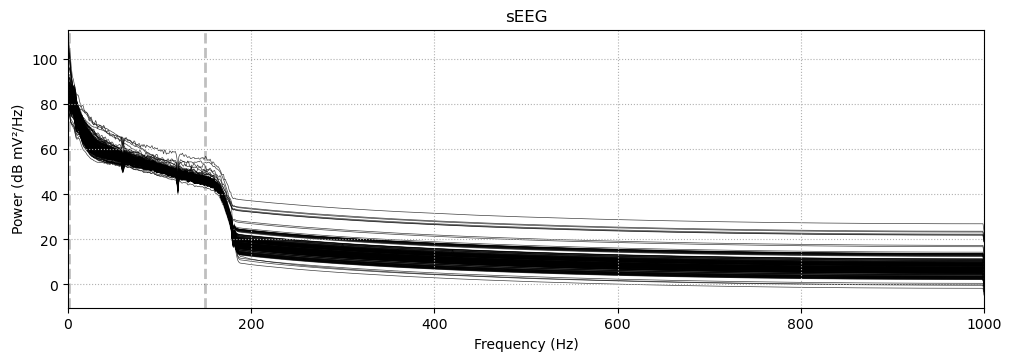

In [ ]:
# plot psd of all channels #

# filtered_notch_data.plot_psd()

## Save Files

In [16]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)


Writing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_notched_filtered_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_notched_filtered_clean_ieeg.fif
Writing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_notched_filtered_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_notched_filtered_clean_ieeg-1.fif
[done]
Writing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_raw_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_raw_clean_ieeg.fif
Writing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_raw_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH051/ieeg/BJH051_raw_clean_ieeg-1.fif
[done]
